In [1]:
import dask.dataframe as dd
import contextily as cx
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
filter_string = ' & '.join(
    (
        '(1 <= PULocationID) & (PULocationID <= 263)',
        '(1 <= DOLocationID) & (DOLocationID <= 263)'
    )
)

pre_covid_data = dd.read_parquet(
    path='2019',
    columns=['PULocationID', 'DOLocationID']
)

covid_data = dd.read_parquet(
    path='2020',
    columns=['PULocationID', 'DOLocationID']
)

pre_covid_data = pre_covid_data.query(filter_string)
covid_data = covid_data.query(filter_string)

### Földrajzi adatok beolvasása

In [3]:
data = (
    gpd
    .read_file(
        filename='taxi_zones/taxi_zones.shp',
        ignore_fields=['Shape_Leng', 'Shape_Area', 'LocationID', 'borough']
    )
    .set_index('OBJECTID')
    .rename_axis('LocationID')
    .rename(columns={'zone': 'Zone'})
)

### Körzetadatok összegzése

In [4]:
%%time

data['PUFrequencyPrC'] = (
    pre_covid_data
    .PULocationID
    .value_counts()
    .compute()
    .reindex_like(data)
    .fillna(value=1)
)

data['DOFrequencyPrC'] = (
    pre_covid_data
    .DOLocationID
    .value_counts()
    .compute()
    .reindex_like(data)
    .fillna(value=1)
)

data['PUFrequencyC'] = (
    covid_data
    .PULocationID
    .value_counts()
    .compute()
    .reindex_like(data)
    .fillna(value=1)
)

data['DOFrequencyC'] = (
    covid_data
    .DOLocationID
    .value_counts()
    .compute()
    .reindex_like(data)
    .fillna(value=1)
)

CPU times: total: 27.6 s
Wall time: 7.34 s


### Differencia adatok képzése

In [5]:
data['PUDifference'] = np.log10(data['PUFrequencyC'] / data['PUFrequencyPrC'])
data['DODifference'] = np.log10(data['DOFrequencyC'] / data['DOFrequencyPrC'])

### Kirajzolás

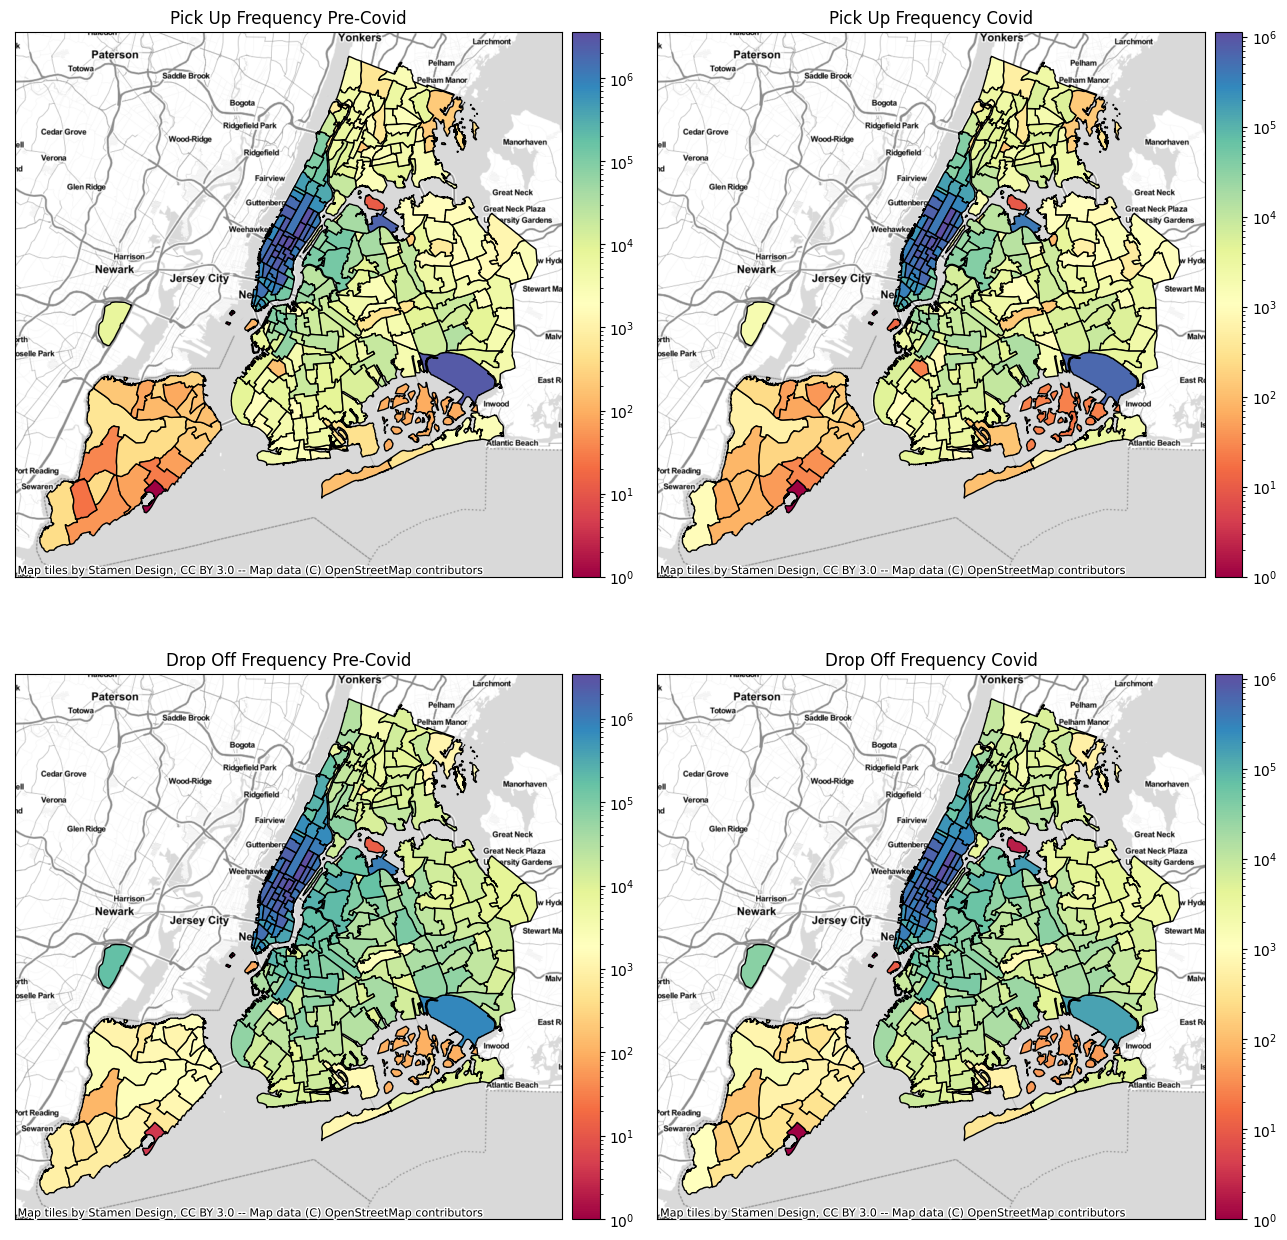

In [6]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(2, 2, figsize=(13, 13))

fig.tight_layout()

title_array = np.array(
    [['Pick Up Frequency Pre-Covid', 'Pick Up Frequency Covid'],
     ['Drop Off Frequency Pre-Covid', 'Drop Off Frequency Covid']]
)

colour_array = np.array(
    [[data['PUFrequencyPrC'], data['PUFrequencyC']], 
     [data['DOFrequencyPrC'], data['DOFrequencyC']]]
)

data_wm = data.to_crs(epsg=3857)

for row in range(2):
    for column in range(2):
        ax[row, column].title.set_text(title_array[row, column])
        
        ax[row, column].set_xticks([])
        ax[row, column].set_yticks([])
        
        coloured_map = data_wm.plot(
            cmap='Spectral',
            column=colour_array[row, column],
            norm=LogNorm(vmin=colour_array[row, column].min(), vmax=colour_array[row, column].max()),
            ax=ax[row, column],
            edgecolor='black',
            legend=True,
            cax=(make_axes_locatable(ax[row, column])
                 .append_axes('right', size='5%', pad=0.1))
        )

        cx.add_basemap(coloured_map, source=cx.providers.Stamen.TonerLite)

plt.show()

In [7]:
data_wm.explore(
    column=data['PUDifference'],
    tooltip='Zone',
    cmap='Spectral',
    legend=False,
    popup=['Zone', 'PUFrequencyPrC', 'PUFrequencyC'],
    tiles='Stamen TonerLite',
    style_kwds=dict(color='black')
)

In [8]:
data_wm.explore(
    column=data['DODifference'],
    tooltip='Zone',
    cmap='Spectral',
    legend=False,
    popup=['Zone', 'PUFrequencyPrC', 'PUFrequencyC'],
    tiles='Stamen TonerLite',
    style_kwds=dict(color='black')
)